# Xpressions of Twitter - Sentiment Analysis at Scale

In the era of large data, X (ex-Twitter) has become a very valuable instrument for researching what the public thinks and feels. This project is based on the datasets, including 1’600’000 tweets. 

The goal is to carry out **sentiment analysis** of tweet data utilizing sophisticated data processing techniques and models to obtain informative output. It relies on technologies such as **Hadoop, Spark, MongoDB, and Python** from the very beginning (EDA and pre-processing) to the end (modelling and analysis). 

The findings of this research not only contribute to a deeper understanding of sentiment dynamics on social media but also offer insights into optimizing data processing pipelines and modelling techniques for future endeavours in sentiment analysis and big data analytics.

<a class="anchor" id="0.1"></a>
# Table of Contents
### [0. Setup](#0)
### [1. Data loading, EDA and Data Visualization and preprocessing](#1)
* [*1.1 Data loading*](#1.1)
* [*1.2 EDA*](#1.2)
* [*1.3 Missing values*](#1.3)
* [*1.4 Duplicates*](#1.4)
* [*1.5 Datetime extraction*](#1.5)

### [2. Sentiment analysis](#2)
* [*2.1 VADER Sentimental Analysis*](#2.1)
* [*2.2 Saving dataset to MongoDB and Hadoop*](#2.2)
* [*2.3 Sentiment Polarity Analysis and Distribution*](#2.3)
* [*2.4 Word frequency*](#2.4)
* [*2.5 Word Cloud*](#2.5)
* [*2.6 Distribution of Tweets by Polarity Over Time*](#2.6)
* [*2.7 LDA models for analyzing tweet topics across different time periods*](#2.7)
* [*2.8 Global events analysis*](#2.8)
* [*2.9 Bigrams, Trigrams, Quadgrams*](#2.9)
* [*2.10 Sentiment Polarity Classifier*](#2.10)
  * [*2.10.1 Creating the model*](#2.10.1)
  * [*2.10.2 Hyperparameter tuning*](#2.10.2)

<a class="anchor" id="0"></a>
## Setup
[Back to Table of Contents](#0.1)

Install the required libraries.

In [18]:
# pip install pymongo==3.11.4 nltk vaderSentiment wordcloud pyLDAvis tensorflow-macos==2.12.0 keras==2.12.0 pandas numpy matplotlib seaborn pyspark

Import the required libraries.

In [230]:
# Data manipulation and visualization
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations

# Data Visualization
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For data visualization

# Distributed Computing
from pyspark.sql import DataFrameStatFunctions, SparkSession  # For distributed computing
from pyspark.sql.functions import (col, concat, countDistinct, count, date_format, 
                                   isnan, length, lit, min, max, substring, split, 
                                   to_timestamp, udf, when)  # Various functions for column operations in PySpark.from pyspark.sql.types import DateType, DoubleType, IntegerType, StringType, StructType, StructField
from pyspark.sql.types import DateType, DoubleType, IntegerType, StringType, StructType, StructField  # Defining schema and data types in PySpark.

# Date and Time Manipulations
from datetime import datetime, timedelta  # For manipulating dates and times.

# Text Processing and Natural Language Processing (NLP)
import re  # For working with regular expressions.
import string  # For string operations.
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # For sentiment analysis using VADER.
import nltk  # For various NLP tasks like tokenization, stemming, and stopwords removal.
from nltk.stem import PorterStemmer  # For stemming words to their root form.
from nltk.corpus import stopwords  # For removing common stopwords in text preprocessing.
from nltk.tokenize import word_tokenize  # For tokenizing words.
from nltk.probability import FreqDist  # For analyzing word frequency.
from gensim import corpora, models  # For topic modeling and other NLP tasks.
import pyLDAvis.gensim_models as gensimvis  # For visualizing topics in LDA models.
import pyLDAvis  # For visualizing interactive topic models.
from wordcloud import WordCloud  # For creating word cloud visualizations.

# Database Interaction
import pymongo  # For interacting with MongoDB databases.
from pymongo import MongoClient  # For connecting to a MongoDB instance.

# Machine Learning and Deep Learning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, train_test_split  # For splitting data and hyperparameter tuning.
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # For encoding labels and scaling features.
from sklearn.exceptions import ConvergenceWarning  # For handling convergence warnings during model training, particularly in iterative algorithms.
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error  # For evaluating model performance.
from keras.preprocessing.text import Tokenizer  # For tokenizing text data.
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences to the same length.
from keras.models import Sequential  # For creating sequential models.
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D  # For building neural network layers.
from keras.utils import plot_model  # For visualizing Keras models.
from keras.wrappers.scikit_learn import KerasRegressor  # For using Keras models with scikit-learn.
from keras.callbacks import EarlyStopping  # For stopping training when a monitored metric has stopped improving.

# Additional Tools and Utilities
from tqdm import tqdm  # For displaying progress bars.
from PIL import Image  # For image processing.
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder, QuadgramCollocationFinder  # For finding collocations in text data.

# Suppressing warnings and unnecessary logs
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

<a class="anchor" id="1"></a>
## 1. Data loading, EDA, Data Visualization and Preprocessing
[Back to Table of Contents](#0.1)

The processing and storage of data in this project involved various steps, beginning with the raw CSV files being loaded onto Hadoop Distributed File System (HDFS). After that, the data was accessed and processed using Apache Spark. The processing activities including EDA, data preparation, and transformation were performed. Spark's distributed processing abilities were applied, through which large quantities of data could be adequately processed. MapReduce based operations implemented when required for parallel data processing.

<a class="anchor" id="1.1"></a>
### 1.1 Data loading

In [2]:
# Check the address of the Spark Master
sc.master

'local[*]'

Creating the Spark Session and loading file from Hadoop

In [29]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName('Tweets analysis') \
    .getOrCreate()

# Specify the Hadoop file path
hadoop_file_path = "hdfs://localhost:9000/ProjectTweets.csv"

# Read the CSV file into a Spark DataFrame
df_tweet = spark.read.csv(hadoop_file_path, header=False)

<a class="anchor" id="1.2"></a>
### 1.2 EDA

In [10]:
# Checking the file the schema
df_tweet.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)



The file schema represents the structure of a dataset with six columns, all of which are of type string and can contain null values. The columns are labeled from _c0 to _c5.

In [6]:
# Checking first 5 rows
df_tweet.show(5)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+---+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows



Let's check the delimiter used in the dataset.

In [7]:
# Extract the first line of the file
first_line = df_tweet.head(1)[0]

# Determine the delimiter by counting occurrences of common delimiters
delimiters = [',', ';', '\t', '|']  # Common delimiters: comma, semicolon, tab, vertical bar
# Count occurrences of each delimiter in the first line
delimiter_counts = [(delimiter, first_line.count(delimiter)) for delimiter in delimiters]

# Get the delimiter with the highest count
most_common_delimiter = max(delimiter_counts, key=lambda x: x[1])[0]

# Print the most common delimiter
print("The delimiter is:", repr(most_common_delimiter))

The delimiter is: ','


Let's save the dataset to MongoDB using PySpark. MongoDB permits an agile and scalable storage of unstructured data thus making it a perfect candidate for storing a massive volume of tweets of different structures. Although the initial data is CSV format, MongoDB's schema-less design provides the benefits of simple adaptation and quick querying of the data that continues to evolve with time. Thus, the database was selected for it.

In [9]:
# Write the DataFrame to MongoDB
df_tweet.write.format("com.mongodb.spark.sql.DefaultSource") \
    .option("spark.mongodb.output.uri", "mongodb://localhost:27017/twitterdb.tweets") \
    .mode("overwrite") \
    .save()

Check the collections in MongoDB to verify that tweets data has been saved correctly.

In [7]:
# Connect to MongoDB and choose the database
collection_names = MongoClient('mongodb://localhost:27017/')['twitterdb'].list_collection_names()

# Print the list of collections in the 'twitterdb' database
print("Collections in the database:")
for collection_name in collection_names:
    print(collection_name)

Collections in the database:
tweets


Let's load data from the MongoDB collection and verify if everything was imported correctly.

In [26]:
# Read data from MongoDB collection into PySpark DataFrame
df_from_mongo = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("spark.mongodb.input.uri", "mongodb://localhost:27017/twitterdb.tweets") \
    .load()

In [27]:
# Show the DataFrame schema
df_from_mongo.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [213]:
# Show the first 5 rows of the DataFrame
df_from_mongo.show(5)

+---+----------+--------------------+--------+---------------+--------------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|                 _id|
+---+----------+--------------------+--------+---------------+--------------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|{663f89a8a6fad933...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|{663f89a8a6fad933...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|{663f89a8a6fad933...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|{663f89a8a6fad933...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|{663f89a8a6fad933...|
+---+----------+--------------------+--------+---------------+--------------------+--------------------+
only showing top 5 rows



New column '_id' was added after exporting from MongoDB. The _id field is a standard feature of MongoDB documents and serves as the primary key for each document in the collection.

Let's check the shape of dataset.

In [28]:
# Create a function to print the shape of a PySpark dataset
def pyspark_shape(df):
    num_rows = df.count()
    num_columns = len(df.columns)
    print('Shape of the dataset:', num_rows, 'rows', num_columns, 'columns')

In [29]:
# Check the shape of dataset
pyspark_shape(df_from_mongo)

Shape of the dataset: 1600000 rows 7 columns


The dataset contains 1,600,000 rows and 7 columns.

Rename the columns names based on the metadata specified in CA's task and reset the MongoDB indexes.

In [30]:
# Rename the columns
df_from_mongo = df_from_mongo \
    .withColumnRenamed("_c0", "index") \
    .withColumnRenamed("_c1", "tweet_ids") \
    .withColumnRenamed("_c2", "date") \
    .withColumnRenamed("_c3", "flag") \
    .withColumnRenamed("_c4", "user") \
    .withColumnRenamed("_c5", "text")

# Drop the _id column
df_from_mongo = df_from_mongo.drop("_id")

# Show the DataFrame with renamed columns
df_from_mongo.show()

+-----+----------+--------------------+--------+---------------+--------------------+
|index| tweet_ids|                date|    flag|           user|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|    5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|    6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|    7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|    8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4

The dataset contains columns with IDs, dates/times, and tweet text, user nicknames, as well as a column called ```flag```.

Check the maximum length of a tweet.

In [217]:
# Calculate the length of each text in the "text" column
df_with_length = df_from_mongo.withColumn("text_length", length(col("text")))

# Find the maximum length
max_length = df_with_length.agg({"text_length": "max"}).collect()[0][0]

print("Maximum length of tweet text:", max_length)

Maximum length of tweet text: 374


In [218]:
# Calculate and display descriptive statistics
df_from_mongo.describe().show()

+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|summary|             index|           tweet_ids|                date|    flag|                user|                text|
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|  count|           1600000|             1600000|             1600000| 1600000|             1600000|             1600000|
|   mean|          799999.5|1.9988175522956276E9|                null|    null| 4.325887521835714E9|                null|
| stddev|461880.35968924104|1.9357607362267864E8|                null|    null|5.162733218454887...|                null|
|    min|                 0|          1467810369|Fri Apr 17 20:30:...|NO_QUERY|        000catnap000|                 ...|
|    max|            999999|          2329205794|Wed May 27 07:27:...|NO_QUERY|          zzzzeus111|ï¿½ï¿½ï¿½ï¿½ï¿½ß§...|
+-------+---------------

To improve readability, the output can be converted into a more convenient format by transforming it into a pandas DataFrame.

In [219]:
# Set pandas option to display unlimited columns and rows without truncation
pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.max_rows', None) # Display all rows

# Calculate descriptive statistics and convert the result to a pandas DataFrame
df_from_mongo_descr = df_from_mongo.describe().toPandas()
# Display the resulting pandas DataFrame
df_from_mongo_descr

,summary,index,tweet_ids,date,flag,user,text
0,count,1600000,1600000,1600000,1600000,1600000,1600000
1,mean,799999.5,1.9988175522956276E9,None,None,4.325887521835714E9,None
2,stddev,461880.3596892441,1.9357607362268165E8,None,None,5.16273321845489E10,None
3,min,0,1467810369,Fri Apr 17 20:30:31 PDT 2009,NO_QUERY,000catnap000,exh...
4,max,999999,2329205794,Wed May 27 07:27:38 PDT 2009,NO_QUERY,zzzzeus111,ï¿½ï¿½ï¿½ï¿½ï¿½ß§ï¿½Ç¿ï¿½ï¿½ï¿½ï¿½ï¿½Ð¶ï¿½Øï¿...


Based on the descriptive statistics it is possible to conclude the following:

- All columns have 1600000 observations.
- The column ```flag``` contain only one value, therefore, it does not provide informational value for comparative analysis within this data set.

<a class="anchor" id="1.3"></a>
###  1.3 Missing values

Checking the data on missing values.

In [7]:
# Check for null, None, empty strings, or NaN values in each column
null_df = df_from_mongo.select([count(when((col(c) =='') | \
                                       col(c).isNull() | \
                                       isnan(c), c
                                      )).alias(c)
                           for c in df_from_mongo.columns])

# Convert the PySpark DataFrame to a Pandas DataFrame for simplier visibility
null_df_pd = null_df.toPandas()
# Add a new column to calculate the total count of null-like values across all columns
null_df_pd.insert(0, 'Total Nulls', null_df_pd.sum(axis=1))

# Display the results
null_df_pd

,Total Nulls,index,tweet_ids,date,flag,user,text
0,0,0,0,0,0,0,0


As observed, there are no missing values in the DataFrame.

<a class="anchor" id="1.4"></a>
###  1.4 Duplicates

Checking the data on duplicates.

In [6]:
# Count the number of rows before dropping duplicates
count_before = df_from_mongo.count()

# Drop duplicates
df_no_duplicates = df_from_mongo.dropDuplicates()

# Count the number of rows after dropping duplicates
count_after = df_no_duplicates.count()

# Calculate the number of duplicate rows
num_duplicates = count_before - count_after

# Check if there were any duplicates
if count_before != count_after:
    print("Duplicates were found. Number of rows with duplicates:", num_duplicates)
else:
    print("No duplicates were found.")

No duplicates were found.


Based on the simultaneous check of all columns, no duplicates were found, but let's check count of unique values in each column.

In [7]:
# Create a function to calculate the count of distinct values for each column in the DataFrame.
def calculate_unique_counts(df):
    # Calculate the count of distinct values for each column
    unique_counts = df.agg(*(countDistinct(col).alias(col) for col in df.columns))
    # Show the results
    return unique_counts.show()

In [8]:
# Call the function
calculate_unique_counts(df_from_mongo)

+-------+---------+------+----+------+-------+
|  index|tweet_ids|  date|flag|  user|   text|
+-------+---------+------+----+------+-------+
|1600000|  1598315|774363|   1|659775|1581466|
+-------+---------+------+----+------+-------+



All values in 'index' column are unqiue, let's exclude the column and check the duplicates again.

In [31]:
# Count the number of rows before dropping duplicates
count_before = df_from_mongo.count()

# Drop duplicates, excluding the 'index' column
df_no_duplicates = df_from_mongo.dropDuplicates(subset=[c for c in df_from_mongo.columns if c != 'index'])

# Count the number of rows after dropping duplicates
count_after = df_no_duplicates.count()

# Calculate the number of duplicate rows
num_duplicates = count_before - count_after

# Check if there were any duplicates
if count_before != count_after:
    print("Duplicates were found. Number of rows with duplicates:", num_duplicates)
else:
    print("No duplicates were found.")

Duplicates were found. Number of rows with duplicates: 1685


As seen, excluding the index column, which contains just sequential row numbers in the dataset, there were a total of 1685 duplicates. 

Let's remove the duplicates and check the dataset's shape to confirm that the duplicates have been removed.

In [32]:
# Re-check the shape of the dataset after duplicates removal
pyspark_shape(df_no_duplicates)

Shape of the dataset: 1598315 rows 6 columns


Duplicates were removed.

<a class="anchor" id="1.5"></a>
### 1.5 Datetime extraction

For simplicity of data manipulation, let's extract the datetime from ```data``` column into its constituent parts:
- weekday,
- month, 
- day,
- year,
- timezone,
and examine the data in the new columns.

Also, let's drop columns that are not of interest for analysis and for anonymizing the dataset:
- index,
- flag,
- user.

In [33]:
# Remove columns 'index', 'flag', and 'user'
columns_to_drop = ['index', 'flag', 'user']
df_without_columns = df_no_duplicates.drop(*columns_to_drop)

# Create new columns
df_with_new_columns = df_without_columns.withColumn("weekday", substring(col("date"), 1, 3)) \
    .withColumn("month", substring(col("date"), 5, 3)) \
    .withColumn("day", substring(col("date"), 9, 2)) \
    .withColumn("year", substring(col("date"), -4, 4)) \
    .withColumn("time", substring(col("date"), 12, 8)) \
    .withColumn("timezone", substring(col("date"), -8, 3))

# Show the DataFrame with new columns
df_with_new_columns.show()

+----------+--------------------+--------------------+-------+-----+---+----+--------+--------+
| tweet_ids|                date|                text|weekday|month|day|year|    time|timezone|
+----------+--------------------+--------------------+-------+-----+---+----+--------+--------+
|1467814883|Mon Apr 06 22:20:...|im sad now  Miss....|    Mon|  Apr| 06|2009|22:20:52|     PDT|
|1467852031|Mon Apr 06 22:30:...|getting sick  tim...|    Mon|  Apr| 06|2009|22:30:34|     PDT|
|1467856044|Mon Apr 06 22:31:...|Crazy wind today ...|    Mon|  Apr| 06|2009|22:31:35|     PDT|
|1467905378|Mon Apr 06 22:44:...|Wow. The most dep...|    Mon|  Apr| 06|2009|22:44:52|     PDT|
|1551459611|Sat Apr 18 09:06:...|@vdebolt oh ok! t...|    Sat|  Apr| 18|2009|09:06:51|     PDT|
|1551522129|Sat Apr 18 09:16:...|       sign twitter |    Sat|  Apr| 18|2009|09:16:43|     PDT|
|1551523432|Sat Apr 18 09:16:...|Happy birthday wo...|    Sat|  Apr| 18|2009|09:16:54|     PDT|
|1551554008|Sat Apr 18 09:21:...|Neat, h

In [77]:
# Check unique values
calculate_unique_counts(df_with_new_columns)

+---------+------+-------+-------+-----+---+----+-----+--------+
|tweet_ids|  date|   text|weekday|month|day|year| time|timezone|
+---------+------+-------+-------+-----+---+----+-----+--------+
|  1598315|774363|1581466|      7|    3| 29|   1|86386|       1|
+---------+------+-------+-------+-----+---+----+-----+--------+



As seen, the dataset contains 7 unique weekdays, spanning across 3 months within a single year, with specific timestamps for each tweet, all within the same timezone.
Additionally, there are only 29 unique days within the month, which may indicate the presence of missing data. Let's investigate further.

In [91]:
# Select distinct values from the "day" column
unique_days = df_with_new_columns.select("day").distinct().withColumn("day", col("day").cast(IntegerType()))

# Create a DataFrame with numbers representing days from 1 to 31
all_days = spark.range(1, 32)

# Find the missing days
missing_days = all_days.subtract(unique_days)

# Show the missing days
missing_days.show()

+---+
| id|
+---+
| 12|
|  8|
+---+



There is no data available for tweets on the 8th and 12th of the month.

Let's combine the data to obtain information about the datetime in the convenient format. Also let's remove unnecessary columns about date.

In [34]:
# Remove columns 'date', 'timezone'
df_without_date_timezone = df_with_new_columns.drop("date", "timezone")

# Create a new column "datetime" by concatenating values from "year", "month", "day", and "time"
df_with_datetime = df_without_date_timezone.withColumn(
    "datetime",
    to_timestamp(
        concat(
            col("year"), 
            col("month"), 
            col("day"), 
            col("time")
        ), 
        "yyyyMMMddHH:mm:ss"
    )
)

# Drop the original columns "year", "month", "day", and "time"
df_final = df_with_datetime.drop("year", "month", "day", "time")
df_final.show()


+----------+--------------------+-------+-------------------+
| tweet_ids|                text|weekday|           datetime|
+----------+--------------------+-------+-------------------+
|1467814883|im sad now  Miss....|    Mon|2009-04-06 22:20:52|
|1467852031|getting sick  tim...|    Mon|2009-04-06 22:30:34|
|1467856044|Crazy wind today ...|    Mon|2009-04-06 22:31:35|
|1467905378|Wow. The most dep...|    Mon|2009-04-06 22:44:52|
|1551459611|@vdebolt oh ok! t...|    Sat|2009-04-18 09:06:51|
|1551522129|       sign twitter |    Sat|2009-04-18 09:16:43|
|1551523432|Happy birthday wo...|    Sat|2009-04-18 09:16:54|
|1551554008|Neat, hopefully m...|    Sat|2009-04-18 09:21:44|
|1551584298|@OsmentEmily Hell...|    Sat|2009-04-18 09:26:36|
|1551680574|still on kash's t...|    Sat|2009-04-18 09:41:46|
|1467966260|@InYourEyes2410 I...|    Mon|2009-04-06 23:02:00|
|1468035840|@Sephystryx I've ...|    Mon|2009-04-06 23:22:31|
|1468054887|There's an inch o...|    Mon|2009-04-06 23:28:32|
|1551906

In [35]:
# Double-check the schema and columns types
df_final.printSchema()

root
 |-- tweet_ids: string (nullable = true)
 |-- text: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- datetime: timestamp (nullable = true)



Let's investigate in days missing

In [36]:
# Find the minimum and maximum dates in the dataset
min_max_dates = df_final.agg(min("datetime").alias("min_date"), max("datetime").alias("max_date"))

# Show the results
min_max_dates.show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2009-04-06 22:19:45|2009-06-25 10:28:31|
+-------------------+-------------------+



The dataset contains data from 2009-04-06 to 2009-06-25.

Calculate the count of tweets for each day.

In [109]:
# Group by date and count the tweets
tweets_per_day = df_final.groupBy(date_format("datetime", "yyyy-MM-dd").alias("date")).agg(count("tweet_ids").alias("tweet_count"))

# Sort the dataset by date
tweets_per_day_sorted = tweets_per_day.orderBy("date")

# Convert DataFrame to Pandas DataFrame for plotting
tweets_per_day_pd = tweets_per_day_sorted.toPandas()
# Convert the "date" column to datetime type
tweets_per_day_pd['date'] = pd.to_datetime(tweets_per_day_pd['date'])
tweets_per_day_pd

,date,tweet_count
0,2009-04-06,3354
1,2009-04-07,17289
2,2009-04-17,3083
3,2009-04-18,21732
4,2009-04-19,27433
5,2009-04-20,18433
6,2009-04-21,8579
7,2009-05-01,7708
8,2009-05-02,27402
9,2009-05-03,35288


As seen, there are some dates missing within the period. Let's investigate further and fill in the missing dates with zeros. 

In [153]:
# Get the minimum and maximum dates from the tweets_per_day_pd dataset
min_date = tweets_per_day_pd['date'].min()
max_date = tweets_per_day_pd['date'].max()

# Generate a DataFrame with all dates from min_date to max_date
all_dates_df = pd.DataFrame({'date': pd.date_range(start=min_date, end=max_date, freq='D')})

# Left join with the existing DataFrame containing tweet counts
all_dates_merged_df = all_dates_df.merge(tweets_per_day_pd, on='date', how='left')

# Fill missing tweet counts with 0
all_dates_merged_df['tweet_count'] = all_dates_merged_df['tweet_count'].fillna(0)

# Display the DataFrame
all_dates_merged_df

,date,tweet_count
0,2009-04-06,3354.0
1,2009-04-07,17289.0
2,2009-04-08,0.0
3,2009-04-09,0.0
4,2009-04-10,0.0
5,2009-04-11,0.0
6,2009-04-12,0.0
7,2009-04-13,0.0
8,2009-04-14,0.0
9,2009-04-15,0.0


Let's plot a graph for clarity.

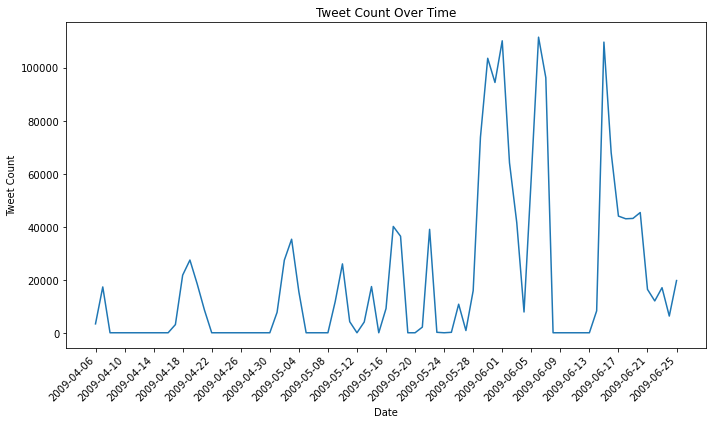

In [158]:
# Convert the "date" and "tweet_count" columns to numpy arrays
dates = all_dates_merged_df['date'].values
tweet_count = all_dates_merged_df['tweet_count'].values

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(dates, tweet_count)
plt.title('Tweet Count Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
# plt.grid(True)
plt.xticks(dates[::4], rotation=45, ha='right')
plt.tight_layout()
plt.show()

Now it is clear that some data not available in some intervals in the whole time span. Best option to fill the data will be to receive/request the missing data from the source, but for purpose of the CA we can manage the current dataset. 

The data imputation methods like interpolation, forward fill, mean, etc. could be used to fill in the tweet counts on the days with missing data. Nevertheless, this would not be able to recapture those tweets' emotional flavor, so I decide not to do it right now. Sentiment analysis could be done by using the current dataset without filling the missing data.

Another thing to consider is that towards the end of the period, beginning around June, the number of tweets goes up significantly. Further investigation is required.

Let's determine the top 20 most popular tweets and count how often they appear.

In [37]:
# Group by the 'text' column and count the occurrences of each comment
top_comments = df_final.groupBy('text').count()

# Order by count in descending order to get the most popular comments
top_comments = top_comments.orderBy(col('count').desc())

# Show the top 20 most popular comments
top_comments.show(20, truncate=False)

+-------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                   |count|
+-------------------------------------------------------------------------------------------------------+-----+
|isPlayer Has Died! Sorry                                                                               |210  |
|good morning                                                                                           |118  |
|headache                                                                                               |115  |
|Good morning                                                                                           |112  |
|Headache                                                                                               |106  |
| cant afford to see Angels and Demons, so i watched it for free: http://tr.im/lvBu                     

- The most common tweet is "isPlayer Has Died! Sorry" what is could be connected with a multiplayer game or something alike.
- Text such as "good morning", "Good morning," and "Goodnight" and "Good night" repeatedly come with small alterations in capitalization which points out that greetings are often present in the tweets.
- The tweets like "Headache", "Headache", "My Tummy Hurts", "My Head Hurts", "Work", "At Work", and "Off to Work" shows that people tend to focus on their physical condition, daily health problems and their work life.
- The tweets with the hyperlinks imply that there is some level of marketing or sharing og personal experience in tweets.

<a class="anchor" id="2"></a>
## 2. Sentiment analysis
[Back to Table of Contents](#0.1)

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

Before proceeding with sentiment analysis, it's a must to preprocess the text data in order of converting it to lowercase, eliminating URLs, non-alphabetic characters, removing stopwords as well as punctuation and stemming.

In [52]:
# Define a function for cleaning text data
def clean_text(tweet):
    # Convert to lowercase first
    tweet = tweet.lower()
    
    # Remove URLs
    cleaned_tweet = re.sub(r'http\S+|www\S+', '', tweet)
    
    # Replace non-alphabetic characters with space
    cleaned_tweet = re.sub('[^a-zA-Z]', ' ', cleaned_tweet)
    
    # Split into words
    cleaned_tweet = cleaned_tweet.split()
    
    # Apply stemming and remove stopwords (if needed)
    cleaned_tweet = [stemmer.stem(word) for word in cleaned_tweet if (word not in stop_words) and (word not in punct)]
    
    # Join the words back into a string
    cleaned_tweet = ' '.join(cleaned_tweet)
    
    return cleaned_tweet

# Register the cleaning function as a UDF (User Defined Function)
clean_text_udf = udf(clean_text, StringType())

# Apply the UDF and create a new DataFrame with the cleaned text column added to df_final
df_final = df_final.withColumn('cleaned_text', clean_text_udf(df_final['text']))

# Display the DataFrame with only the 'text' and 'cleaned_text' columns
df_final.select('cleaned_text').show(truncate=False)

+------------------------------------------------------------------------------+
|cleaned_text                                                                  |
+------------------------------------------------------------------------------+
|im sad miss lilli                                                             |
|get sick time hot tea studi sleeeep                                           |
|crazi wind today bird                                                         |
|wow depress thing world lose video creat matter second fml                    |
|vdebolt oh ok right church tri talk fam go                                    |
|sign twitter                                                                  |
|happi birthday wonder maryana congratul victoria alex                         |
|neat hope twitter util start use flickr like auth via adactio via ronalddevera|
|osmentemili helloooooo england next week hm premier x                         |
|still kash twitter lol she 

<a class="anchor" id="2.1"></a>
### 2.1 VADER Sentimental Analysis

VADER sentiment analysis is a tool designed for detecting sentiments present in social media. It employs a lexicon and a rule-based method to categorize texts into either positive, negative, neutral, or compound sentiments. VADER is particularly efficient for tweets as it handles slang, emoticons, and punctuation well making it good choice when analyzing the depth of sentiments in Twitter databases.

In [54]:
# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

In [55]:
# Create a UDF to apply SentimentIntensityAnalyzer and get the compound score
def get_compound_score(tweet):
    polarity_score = sent_analyzer.polarity_scores(tweet)
    return polarity_score['compound']

# Register the UDF
get_compound_score_udf = udf(get_compound_score, DoubleType())

# Apply the UDF to the 'cleaned_text' column to get the polarity score and create a new column 'score'
df_final_score = df_final.withColumn('score', get_compound_score_udf(df_final['cleaned_text']))

# Display the DataFrame with 'cleaned_text' and 'score' columns
df_final_score.select('cleaned_text', 'score').show()

+--------------------+-------+
|        cleaned_text|  score|
+--------------------+-------+
|   im sad miss lilli|-0.5719|
|get sick time hot...|-0.5106|
|crazi wind today ...|    0.0|
|wow depress thing...|  -0.25|
|vdebolt oh ok rig...|  0.296|
|        sign twitter|    0.0|
|happi birthday wo...|    0.0|
|neat hope twitter...| 0.8126|
|osmentemili hello...|    0.0|
|still kash twitte...| 0.4215|
|     inyourey reckon|    0.0|
|sephystryx look g...| 0.4404|
|inch snow ground ...|-0.4767|
|    beauti day today|    0.0|
|tan littl kick ba...|  0.802|
|sooo freakin gorg...|    0.0|
|              go zoo|    0.0|
|  vacuum camera shop|    0.0|
|keesdekon feed futur|    0.0|
|voituk well learn...|  -0.34|
+--------------------+-------+
only showing top 20 rows



In [58]:
# Define a UDF to assign polarity based on the score value
def assign_polarity(score):
    # If the score is greater than or equal to 0.05, it is considered 'positive'.
    if score >= 0.05:
        return 'positive'
    # If the score is less than or equal to -0.05, it is considered 'negative'.
    elif score <= -0.05:
        return 'negative'
    # If the score is between -0.05 and 0.05, it is considered 'neutral'.
    else:
        return 'neutral'

# Register the UDF
assign_polarity_udf = udf(assign_polarity, StringType())

# Apply the UDF and create a new column 'polarity'
df_final_sentiment = df_final_score.withColumn('polarity', assign_polarity_udf(df_final_score['score']))

# Display the DataFrame
df_final_sentiment.show(5)

+----------+--------------------+-------+-------------------+--------------------+-------+--------+
| tweet_ids|                text|weekday|           datetime|        cleaned_text|  score|polarity|
+----------+--------------------+-------+-------------------+--------------------+-------+--------+
|1467814883|im sad now  Miss....|    Mon|2009-04-06 22:20:52|   im sad miss lilli|-0.5719|negative|
|1467852031|getting sick  tim...|    Mon|2009-04-06 22:30:34|get sick time hot...|-0.5106|negative|
|1467856044|Crazy wind today ...|    Mon|2009-04-06 22:31:35|crazi wind today ...|    0.0| neutral|
|1467905378|Wow. The most dep...|    Mon|2009-04-06 22:44:52|wow depress thing...|  -0.25|negative|
|1551459611|@vdebolt oh ok! t...|    Sat|2009-04-18 09:06:51|vdebolt oh ok rig...|  0.296|positive|
+----------+--------------------+-------+-------------------+--------------------+-------+--------+
only showing top 5 rows



The final dataset with sentiment score and tweet's polarity is ready.

<a class="anchor" id="2.2"></a>
### 2.2 Saving dataset to MongoDB and Hadoop

In [57]:
# Save the final dataset to MongoDB

df_final_sentiment.write.format("com.mongodb.spark.sql.DefaultSource") \
    .option("spark.mongodb.output.uri", "mongodb://localhost:27017/twitterdb.df_final_sentiment") \
    .mode("overwrite") \
    .save()

Let's also save the dataset from MongoDB to Hadoop using PySpark.

In [59]:
# Read data from MongoDB collection into PySpark DataFrame
df_sentiment_from_mongo = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("spark.mongodb.input.uri", "mongodb://localhost:27017/twitterdb.df_final_sentiment") \
    .load()

# Drop the '_id' column
df_sentiment_from_mongo = df_sentiment_from_mongo.drop('_id')

In [60]:
# Save the DataFrame to a CSV file to Hadoop
df_sentiment_from_mongo.write.csv('hdfs://localhost:9000/CA2_2/df_final_sentiment.csv', header=True, mode="overwrite")

In [61]:
# Re-check the shape of the saved dataset
pyspark_shape(df_final_sentiment)

Shape of the dataset: 1598315 rows 7 columns


It's also possible to use Terminal to save the collection from MongoDB to csv using the following command.

```mongoexport --uri="mongodb://localhost:27017/twitterdb" --collection="df_final_sentiment" --type=csv --fields="tweet_ids,text,weekday,datetime,cleaned_text,score,polarity" --out="/home/hduser/Documents/CA2_2/df_final_sentiment.csv"```

<a class="anchor" id="2.3"></a>
### 2.3 Sentiment Polarity Analysis and Distribution 

The next stages of the analysis will be performed using aggregated final dataset in csv format. 

In [1]:
# Read the final dataset containing sentiment analysis results from a CSV file
df_tw = pd.read_csv('df_final_sentiment.csv')

# Display the first few rows of the dataframe
df_tw.head()

<IPython.core.display.Javascript object>

,tweet_ids,text,weekday,datetime,cleaned_text,score,polarity
0,1467825084,"@Lt_Algonquin agreed, I saw the failwhale alll...",Mon,2009-04-06T22:23:30.000Z,lt algonquin agre saw failwhal allllll day today,0.0000,neutral
1,1467822522,Where did u move to? I thought u were already...,Mon,2009-04-06T22:22:49.000Z,u move thought u alreadi sd hmmm random u foun...,0.6249,positive
2,1467836111,"@makeherfamous hmm , do u really enjoy being ...",Mon,2009-04-06T22:26:22.000Z,makeherfam hmm u realli enjoy problem constant...,0.1280,positive
3,1467825863,i really hate how people diss my bands! Trace...,Mon,2009-04-06T22:23:43.000Z,realli hate peopl diss band trace clearli ugli,-0.5719,negative
4,1467812723,@caregiving I couldn't bear to watch it. And ...,Mon,2009-04-06T22:20:19.000Z,caregiv bear watch thought ua loss embarrass,-0.5423,negative


In [2]:
# Display information about the dataframe
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598315 entries, 0 to 1598314
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   tweet_ids     1598315 non-null  int64  
 1   text          1598315 non-null  object 
 2   weekday       1598315 non-null  object 
 3   datetime      1598315 non-null  object 
 4   cleaned_text  1597695 non-null  object 
 5   score         1598315 non-null  float64
 6   polarity      1598315 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 85.4+ MB


The date format appears to have changed after exporting/importing from the database. Let's correct it.

In [3]:
# Convert the 'datetime' column to datetime format and remove the timezone information.
df_tw['datetime'] = pd.to_datetime(df_tw['datetime']).dt.tz_localize(None)

<IPython.core.display.Javascript object>

In [72]:
# Re-check the displaying of 'datetime' column
df_tw.head()

,tweet_ids,text,weekday,datetime,cleaned_text,score,polarity
0,1467825084,"@Lt_Algonquin agreed, I saw the failwhale alll...",Mon,2009-04-06 22:23:30,lt algonquin agre saw failwhal allllll day today,0.0000,neutral
1,1467822522,Where did u move to? I thought u were already...,Mon,2009-04-06 22:22:49,u move thought u alreadi sd hmmm random u foun...,0.6249,positive
2,1467836111,"@makeherfamous hmm , do u really enjoy being ...",Mon,2009-04-06 22:26:22,makeherfam hmm u realli enjoy problem constant...,0.1280,positive
3,1467825863,i really hate how people diss my bands! Trace...,Mon,2009-04-06 22:23:43,realli hate peopl diss band trace clearli ugli,-0.5719,negative
4,1467812723,@caregiving I couldn't bear to watch it. And ...,Mon,2009-04-06 22:20:19,caregiv bear watch thought ua loss embarrass,-0.5423,negative


In [4]:
# Re-check the type of 'datetime' column
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598315 entries, 0 to 1598314
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   tweet_ids     1598315 non-null  int64         
 1   text          1598315 non-null  object        
 2   weekday       1598315 non-null  object        
 3   datetime      1598315 non-null  datetime64[ns]
 4   cleaned_text  1597695 non-null  object        
 5   score         1598315 non-null  float64       
 6   polarity      1598315 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 85.4+ MB


The ```datetime``` format was corrected.

Let's plot the number and percentages of comments by polarity.

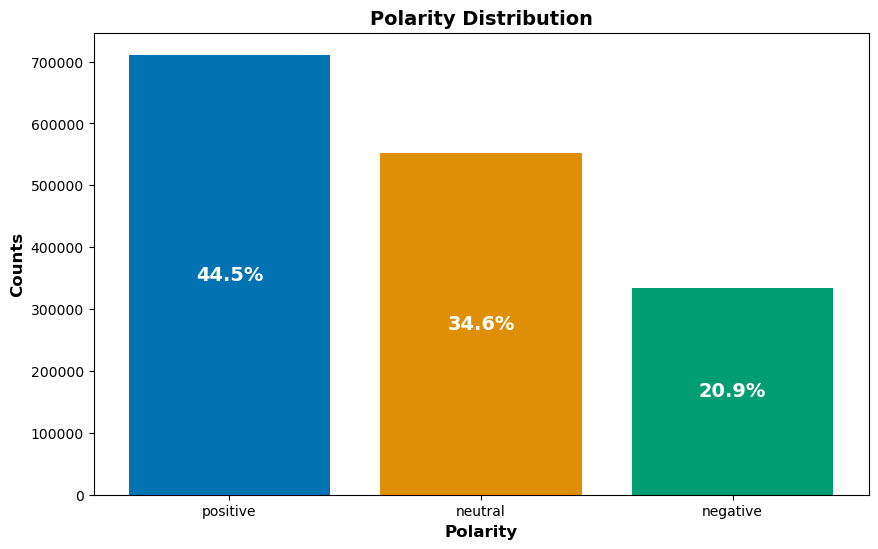

In [216]:
# Calculating the frequency of each polarity value
polarity_counts = df_tw['polarity'].value_counts()

# Determining the total number of comments
total_comments = len(df_tw)

# Computing the percentages for each polarity type based on the total number of comments
percentages = (polarity_counts / total_comments) * 100

# Creating a dataframe with counts and percentages for each polarity type
proportion_df = pd.DataFrame({
    'polarity': polarity_counts.index,
    'counts': polarity_counts.values,
    'percentages': percentages.values
})

# Set colorblind-friendly palette
sns.set_palette("colorblind")

# Define colors
colors = sns.color_palette()

# Plotting the polarity distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(proportion_df['polarity'], proportion_df['counts'], color=colors)
plt.xlabel('Polarity', fontsize=12, fontweight='bold')
plt.ylabel('Counts', fontsize=12, fontweight='bold')
plt.title('Polarity Distribution', fontsize=14, fontweight='bold')

# Adding counts and percentages in the middle of each bar
for bar, count, percent in zip(bars, proportion_df['counts'], proportion_df['percentages']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{percent:.1f}%', ha='center', va='center', color='white', fontsize=14, fontweight='bold')

plt.show()


This analysis shows that roughly half (44. 5%) of the tweets represent the positive polarity, whereas only one-fifth consist of negative polarity.

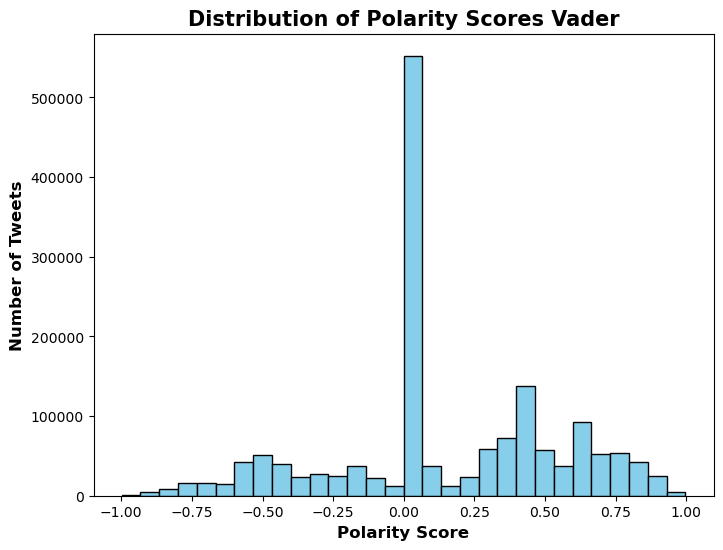

In [206]:
# Creating a histogram for polarity scores
plt.figure(figsize=(8, 6))
plt.hist(df_tw['score'], bins=30, color='skyblue', edgecolor='black')

# Setting title and labels
plt.title('Distribution of Polarity Scores Vader', fontsize=15, fontweight='bold')
plt.xlabel('Polarity Score', fontsize=12, fontweight='bold')
plt.ylabel('Number of Tweets', fontsize=12, fontweight='bold')

# Displaying the histogram
plt.show()

The distribution of tweet polarity clumps around zero with the rest of the tweets being divided among positive and negative sentiments with a tendency towards the positive category.

<a class="anchor" id="2.4"></a>
### 2.4 Word frequency

In [93]:
# Filter out rows where 'cleaned_text' is not NaN
# This is done to handle cases where all words were removed from some tweets during 
# preprocessing, such as during stopword removal.
df_filtered = df_tw[df_tw['cleaned_text'].notna()]

# Extract the values from the 'cleaned_text' column and store them in a list
cleaned_data = df_filtered['cleaned_text'].tolist()

# Convert all comments into a single text
all_tweets = ' '.join(cleaned_data)

# Tokenize the text
tokenized_word = word_tokenize(all_tweets)

# Calculate word frequency
fdist = FreqDist(tokenized_word)

# Display word frequency
print(fdist.most_common(10))

[('go', 138553), ('get', 110710), ('day', 109230), ('good', 92463), ('work', 87756), ('like', 83773), ('love', 82932), ('quot', 73277), ('got', 70978), ('today', 68581)]


<Figure size 1200x800 with 0 Axes>

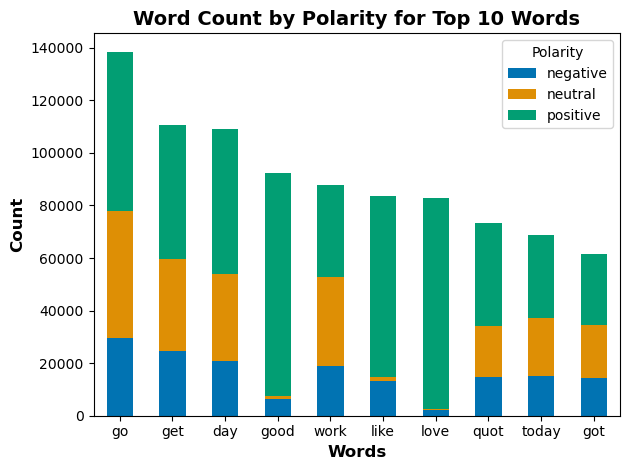

In [222]:
# Get the top 10 most common words from the frequency distribution
top_words = [word for word, freq in fdist.most_common(10)]

# Create a copy of the df_tw dataset to make changes without altering the original
df_tw_copy = df_tw.copy()

# Remove rows with NaN values in the 'cleaned_text' column
df_tw_copy = df_tw_copy.dropna(subset=['cleaned_text'])

# Filter the copy of the dataset to get rows containing the top words
df_top_words = df_tw_copy[df_tw_copy['cleaned_text'].str.contains('|'.join(top_words), na=False)]

# Split 'cleaned_text' into words and expand into a new DataFrame
words_df = df_top_words['cleaned_text'].str.split(expand=True).stack().reset_index(level=1, drop=True)
words_df = words_df[words_df.isin(top_words)].reset_index(name='word')

# Merge with df_tw_copy to get the polarity of each word
words_polarity_df = words_df.merge(df_tw_copy[['tweet_ids', 'polarity']], left_on='index', right_index=True)

# Count the frequency of each word by polarity
word_polarity_count = words_polarity_df.groupby(['word', 'polarity']).size().reset_index(name='count')

# Prepare the data for a stacked bar chart
pivot_df = word_polarity_count.pivot(index='word', columns='polarity', values='count').fillna(0)

# Sort the columns in the pivot table from highest to lowest total count
pivot_df['total_count'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='total_count', ascending=False).drop(columns='total_count')

# Set colorblind-friendly palette
sns.set_palette("colorblind")

# Set up the size of the plot
plt.figure(figsize=(12, 8))

# Create a stacked bar chart
pivot_df.plot(kind='bar', stacked=True)

# Set up the plot
plt.xlabel('Words', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Word Count by Polarity for Top 10 Words', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.legend(title='Polarity')
plt.tight_layout()
plt.show();

The top-10 words demonstrated the almost equal distribution of polarity which showed the overall polarity trend of the dataset. Yet, the amount of words such as ```good```, ```like```, and ```love``` is comparatively much higher in tweets that show positive feelings.

<a class="anchor" id="2.5"></a>
### 2.5 Word Cloud

In [58]:
# Importing mask
cct_mask = np.array(Image.open('resources/hireme.jpg'))

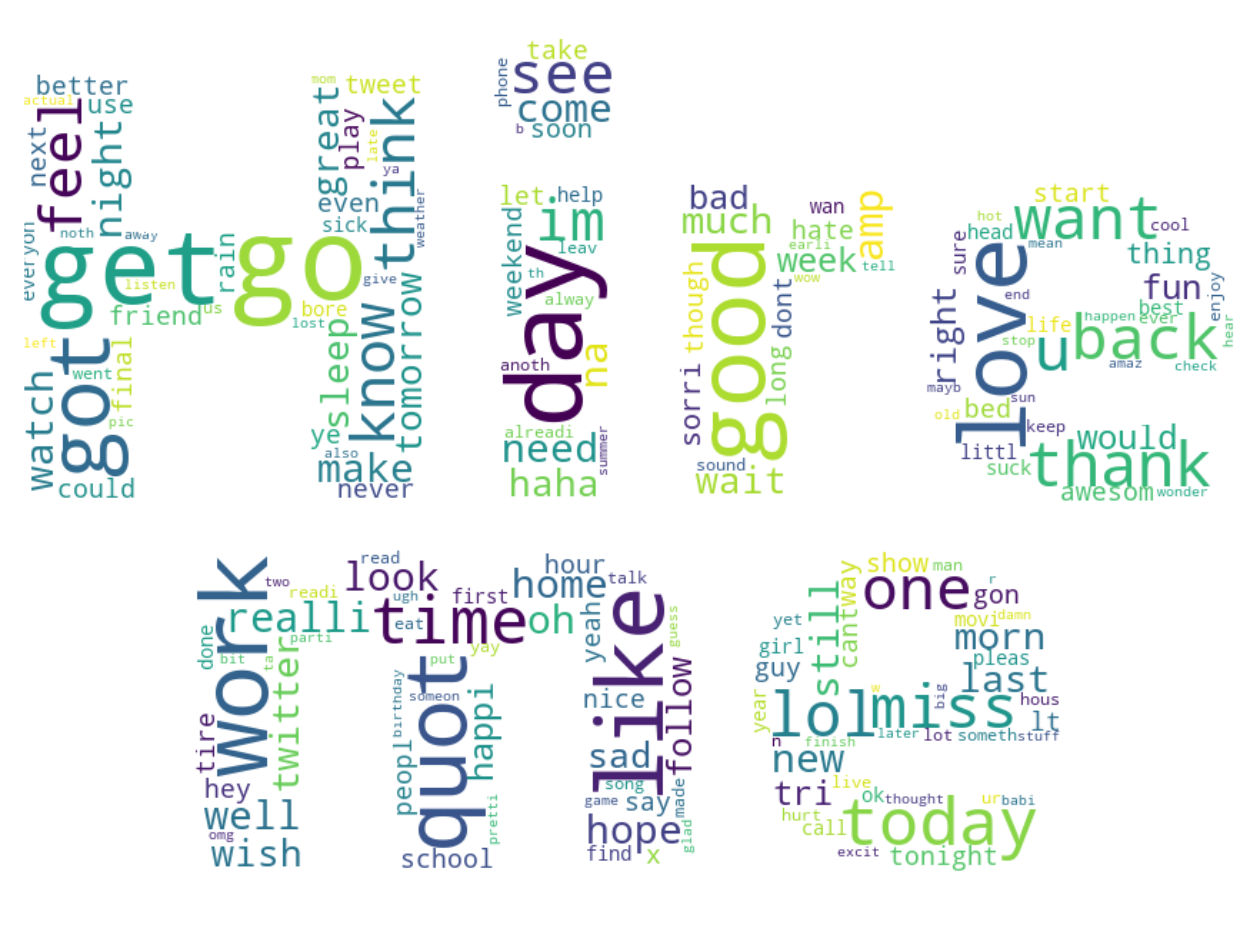

In [84]:
# Plot the wordcloud with the mask applied
wc = WordCloud(
    background_color='#FFFFFF',
    mask=cct_mask,
    contour_width=2,
    contour_color='#FFFFFF',
    random_state=123
).generate_from_frequencies(fdist)

plt.figure(figsize=[16,16])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show();

Also, let's plot Wordclouds for tweets with different polarities.

Top 10 words for neutral polarity: [('go', 48530), ('get', 35179), ('work', 33814), ('day', 33161), ('got', 22822), ('today', 22162), ('back', 20014), ('time', 20006), ('quot', 19244), ('one', 16056)]


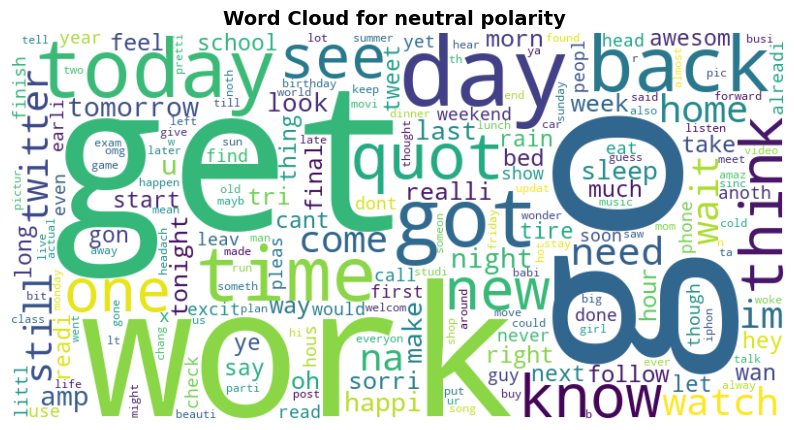

Top 10 words for positive polarity: [('good', 85091), ('love', 80412), ('like', 68903), ('go', 60594), ('thank', 56569), ('day', 55232), ('lol', 52352), ('get', 51025), ('want', 43589), ('hope', 41054)]


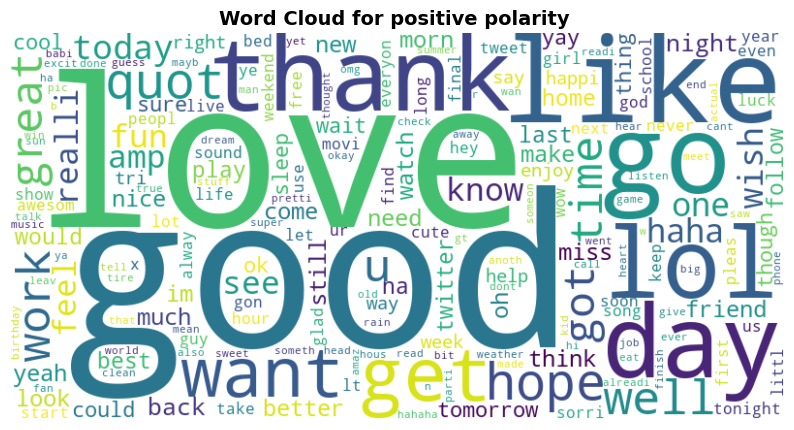

Top 10 words for negative polarity: [('miss', 36174), ('go', 29429), ('get', 24506), ('sad', 24268), ('bad', 22500), ('day', 20837), ('hate', 20102), ('work', 18930), ('feel', 16712), ('got', 16306)]


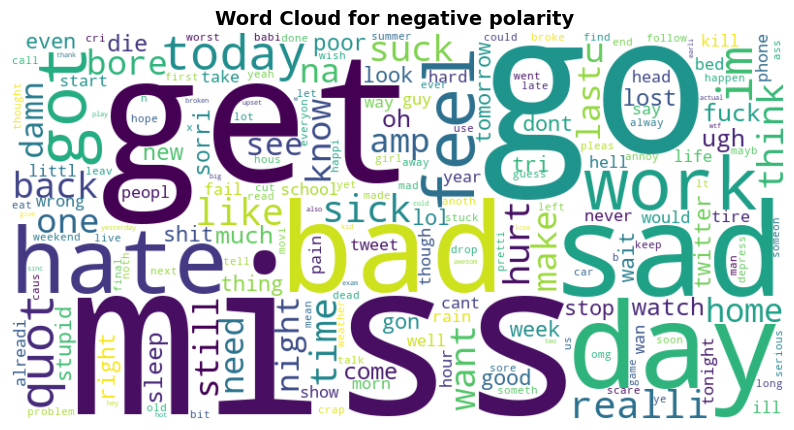

In [224]:
# Define the polarities for which you want to create word clouds
polarities = df_tw['polarity'].unique()

# Iterate over each polarity
for polarity in polarities:
    # Filter the dataframe for the current polarity
    df_filtered = df_tw[df_tw['polarity'] == polarity]
    
    # Filter out rows where 'cleaned_text' is not NaN
    df_filtered = df_filtered[df_filtered['cleaned_text'].notna()]

    # Extract the values from the 'cleaned_text' column and store them in a list
    cleaned_data = df_filtered['cleaned_text'].tolist()

    # Convert all comments into a single text
    all_tweets = ' '.join(cleaned_data)

    # Tokenize the text
    tokenized_word = word_tokenize(all_tweets)

    # Calculate word frequency
    fdist = FreqDist(tokenized_word)

    # Display word frequency
    print(f"Top 10 words for {polarity} polarity: {fdist.most_common(10)}")

    # Creating a word cloud from the fdist object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fdist)

    # Displaying the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {polarity} polarity ", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()

- Neutral tweets commonly involve everyday activities and experiences like going, getting, and work.
- Positive tweets frequently express positive emotions such as love, gratitude, and hope.
- Negative tweets often contain words associated with negative feelings like missing, sadness, and hate.

<a class="anchor" id="2.6"></a>
### 2.6 Distribution of Tweets by Polarity Over Time

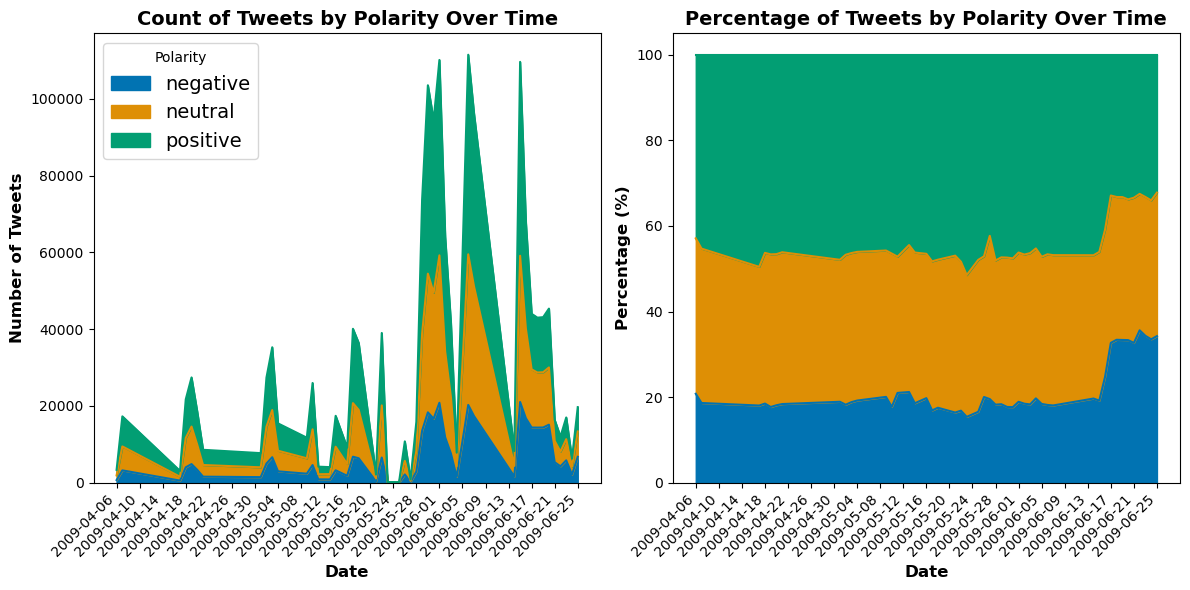

In [228]:
# Create a new dataframe df_new with the desired columns
df_new = df_tw[['polarity', 'datetime']].copy()

# Convert 'datetime' column to datetime format
df_new['datetime'] = pd.to_datetime(df_new['datetime'])

# Extract only the date without time from the 'datetime' column
df_new['date'] = df_new['datetime'].dt.date

# Drop the 'datetime' column if it's no longer needed
df_new.drop(columns=['datetime'], inplace=True)

# Group by 'date' and 'polarity' and count the occurrences
grouped = df_new.groupby(['date', 'polarity']).size().unstack(fill_value=0)

# Calculate the percentage of each polarity per day
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Set colorblind-friendly palette
sns.set_palette("colorblind")

# Create a Figure and two Axes objects
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the first stack plot
date_range = pd.date_range(df_new['date'].min(), df_new['date'].max(), freq='4D')
grouped.plot(kind='area', stacked=True, ax=axs[0])
axs[0].set_title('Count of Tweets by Polarity Over Time', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Date', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Number of Tweets', fontsize=12, fontweight='bold')
axs[0].legend(title='Polarity', loc='best', fontsize=14)
axs[0].set_xticks(date_range)
axs[0].set_xticklabels([date.strftime('%Y-%m-%d') for date in date_range], rotation=45, ha='right')

# Plotting the second stack plot
grouped_percentage.plot(kind='area', stacked=True, ax=axs[1])
axs[1].set_title('Percentage of Tweets by Polarity Over Time', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
axs[1].legend_.remove()
axs[1].set_xticks(date_range)
axs[1].set_xticklabels([date.strftime('%Y-%m-%d') for date in date_range], rotation=45, ha='right')

plt.tight_layout()
plt.show()

It is records a surge in tweets from May 29 with decrease in positive tweets and an increase in negative tweets level from June 17.

<a class="anchor" id="2.7"></a>
### 2.7 LDA models for analyzing tweet topics across different time periods

Let's split the dataset into periods before May 29th, between May 29th and June 16th, and after June 16th for topic analysis of each period using LDA (Latent Dirichlet Allocation) models that are a statistical technique for uncovering the underlying topics within a collection of text documents.

In [15]:
# Filter data for each stage
before_0529 = df_tw[df_tw['datetime'] < '2009-05-29']
between_0529_0616 = df_tw[(df_tw['datetime'] >= '2009-05-29') & (df_tw['datetime'] <= '2009-06-16')]
after_0616 = df_tw[df_tw['datetime'] > '2009-06-16']

# Prepare data for topic modeling (LDA) for each period
texts_before_0529 = [tweet.split() for tweet in before_0529['cleaned_text'].fillna('').tolist()]
dictionary_before_0529 = corpora.Dictionary(texts_before_0529)
corpus_before_0529 = [dictionary_before_0529.doc2bow(text) for text in texts_before_0529]

texts_between_0529_0616 = [tweet.split() for tweet in between_0529_0616['cleaned_text'].fillna('').tolist()]
dictionary_between_0529_0616 = corpora.Dictionary(texts_between_0529_0616)
corpus_between_0529_0616 = [dictionary_between_0529_0616.doc2bow(text) for text in texts_between_0529_0616]

texts_after_0616 = [tweet.split() for tweet in after_0616['cleaned_text'].fillna('').tolist()]
dictionary_after_0616 = corpora.Dictionary(texts_after_0616)
corpus_after_0616 = [dictionary_after_0616.doc2bow(text) for text in texts_after_0616]

# Train LDA models for each period with tqdm progress bars
with tqdm(desc="LDA Before 2009-05-29") as pbar:
    lda_model_before_0529 = models.LdaModel(corpus_before_0529, num_topics=5, id2word=dictionary_before_0529, passes=5)
    pbar.update(1)  # Update progress bar

with tqdm(desc="LDA Between 2009-05-29 and 2009-06-16") as pbar:
    lda_model_between_0529_0616 = models.LdaModel(corpus_between_0529_0616, num_topics=5, id2word=dictionary_between_0529_0616, passes=5)
    pbar.update(1)  # Update progress bar

with tqdm(desc="LDA After 2009-06-16") as pbar:
    lda_model_after_0616 = models.LdaModel(corpus_after_0616, num_topics=5, id2word=dictionary_after_0616, passes=5)
    pbar.update(1)  # Update progress bar

LDA Before 2009-05-29: 1it [02:20, 140.99s/it]
LDA Between 2009-05-29 and 2009-06-16: 1it [05:58, 358.40s/it]
LDA After 2009-06-16: 1it [01:45, 105.15s/it]


In [17]:
# Print topics for period before 2009-05-29
topics_before_0529 = lda_model_before_0529.show_topics(formatted=False)
print("Topics Before 2009-05-29:")
for i, topic in enumerate(topics_before_0529):
    print(f"Topic {i}: {topic}")

Topics Before 2009-05-29:
Topic 0: (0, [('like', 0.028032264), ('get', 0.015132889), ('look', 0.014041976), ('know', 0.013541336), ('lol', 0.012737889), ('think', 0.011434116), ('one', 0.011237755), ('good', 0.01028047), ('realli', 0.009538852), ('oh', 0.009439849)])
Topic 1: (1, [('thank', 0.03571109), ('quot', 0.03566179), ('love', 0.023240354), ('u', 0.022793533), ('twitter', 0.015335238), ('follow', 0.014568495), ('see', 0.011022751), ('lol', 0.010387563), ('hey', 0.009591936), ('x', 0.007825029)])
Topic 2: (2, [('day', 0.03555399), ('go', 0.03296425), ('work', 0.026202533), ('today', 0.02185749), ('good', 0.018087147), ('get', 0.01795411), ('morn', 0.015776511), ('back', 0.013164778), ('time', 0.011888808), ('home', 0.011155938)])
Topic 3: (3, [('watch', 0.02767449), ('love', 0.015718369), ('amp', 0.010940525), ('song', 0.010527523), ('new', 0.009440847), ('listen', 0.00940118), ('movi', 0.009261821), ('hi', 0.007631862), ('music', 0.0074823448), ('pic', 0.0072129047)])
Topic 4: (

In [35]:
# Visualize topics for period before 2009-05-29 using pyLDAvis
vis_before_0529 = gensimvis.prepare(lda_model_before_0529, corpus_before_0529, dictionary_before_0529)
pyLDAvis.display(vis_before_0529)

In [235]:
# Print topics for period between 2009-05-29 and 2009-06-16
topics_between_0529_0616 = lda_model_between_0529_0616.show_topics(formatted=False)
print("\nTopics Between 2009-05-29 and 2009-06-16:")
for i, topic in enumerate(topics_between_0529_0616):
    print(f"Topic {i}: {topic}")


Topics Between 2009-05-29 and 2009-06-16:
Topic 0: (0, [('thank', 0.048795182), ('love', 0.01899621), ('great', 0.015265589), ('look', 0.0150119355), ('day', 0.014185724), ('wait', 0.0120140845), ('new', 0.010749014), ('see', 0.010197785), ('excit', 0.009873402), ('enjoy', 0.009761009)])
Topic 1: (1, [('quot', 0.030287663), ('love', 0.02977409), ('u', 0.024324605), ('lol', 0.019731877), ('like', 0.017716063), ('know', 0.015663113), ('haha', 0.013023411), ('good', 0.010553128), ('hey', 0.009056005), ('say', 0.009027104)])
Topic 2: (2, [('go', 0.03910605), ('good', 0.027103981), ('day', 0.026479099), ('get', 0.01979312), ('today', 0.015297439), ('night', 0.015121445), ('work', 0.014846538), ('time', 0.014532372), ('back', 0.013022917), ('morn', 0.011705639)])
Topic 3: (3, [('watch', 0.023658287), ('follow', 0.02321384), ('amp', 0.011762993), ('play', 0.009769095), ('eat', 0.009057272), ('got', 0.008949661), ('game', 0.007873136), ('new', 0.006385737), ('wanna', 0.0063856626), ('want', 0

In [37]:
# Visualize topics for period between 2009-05-29 and 2009-06-16 using pyLDAvis  
vis_between_0529_0616 = gensimvis.prepare(lda_model_between_0529_0616, corpus_between_0529_0616, dictionary_between_0529_0616)
pyLDAvis.display(vis_between_0529_0616)   

In [237]:
# Print topics for period after 2009-06-16
topics_after_0616 = lda_model_after_0616.show_topics(formatted=False)
print("\nTopics After 2009-06-16:")
for i, topic in enumerate(topics_after_0616):
    print(f"Topic {i}: {topic}")


Topics After 2009-06-16:
Topic 0: (0, [('one', 0.013455601), ('get', 0.0128426915), ('know', 0.012405059), ('twitter', 0.012396325), ('new', 0.010362982), ('need', 0.009342237), ('want', 0.009074214), ('tri', 0.008751476), ('tweet', 0.008399364), ('follow', 0.008241643)])
Topic 1: (1, [('miss', 0.024361268), ('like', 0.019146131), ('love', 0.01614441), ('u', 0.015182989), ('sad', 0.014462327), ('feel', 0.014372372), ('go', 0.013737599), ('wish', 0.013175211), ('day', 0.01313186), ('im', 0.011583304)])
Topic 2: (2, [('oh', 0.023748694), ('last', 0.022971366), ('night', 0.021319358), ('thank', 0.012736149), ('good', 0.0111602545), ('sorri', 0.010260575), ('well', 0.009981645), ('feel', 0.00975708), ('got', 0.008256716), ('eat', 0.007730735)])
Topic 3: (3, [('rain', 0.015747229), ('away', 0.010688818), ('hot', 0.009914811), ('wait', 0.009863502), ('hurt', 0.008816202), ('readi', 0.008563122), ('amp', 0.008377114), ('updat', 0.007545165), ('head', 0.0069151716), ('play', 0.006853447)])
To

In [39]:
# Visualize topics for period after 2009-06-16 using pyLDAvis
vis_after_0616 = gensimvis.prepare(lda_model_after_0616, corpus_after_0616, dictionary_after_0616)
pyLDAvis.display(vis_after_0616)

- Topics before May 29th cover the themes such as the one about good morning, gratitude, work, music, other entertaining activities, and just about everydate activity.
- Topics between May 29th and June 16th cover themes including thanksgiving, conversation about everyday stuff like work and nightlife, Twitter-based conversations, and telling personal stories.
- Topics after May 16th cover the themes with expressions of missing somebody, feelings of sadness, conversations about day-to-day events such as work and going out, as well as updates of own experiences such as eating and feeling sorry.

<a class="anchor" id="2.8"></a>
### 2.8 Global events analysis

A sudden shift in the patterns of dynamic and sentiment of tweets could be tied with some global event that brought an increase in tweets and a change in the type of emotions.
Let's create a list of words that could be likely to appear in tweets during a global event and for various themes.
- politics: election, vote, candidate, campaign, politics
- disasters: crisis, disaster, pandemic, emergency, tragedy, terrorism
- global events: conflict, peace, negotiation, diplomacy, war
- economy events: economy, recession, market, inflation, unemployment
- sport events: sport, championship, game, victory, defeat
- death of global famous person: rip, condolences, legacy, memorial, tribute, loss

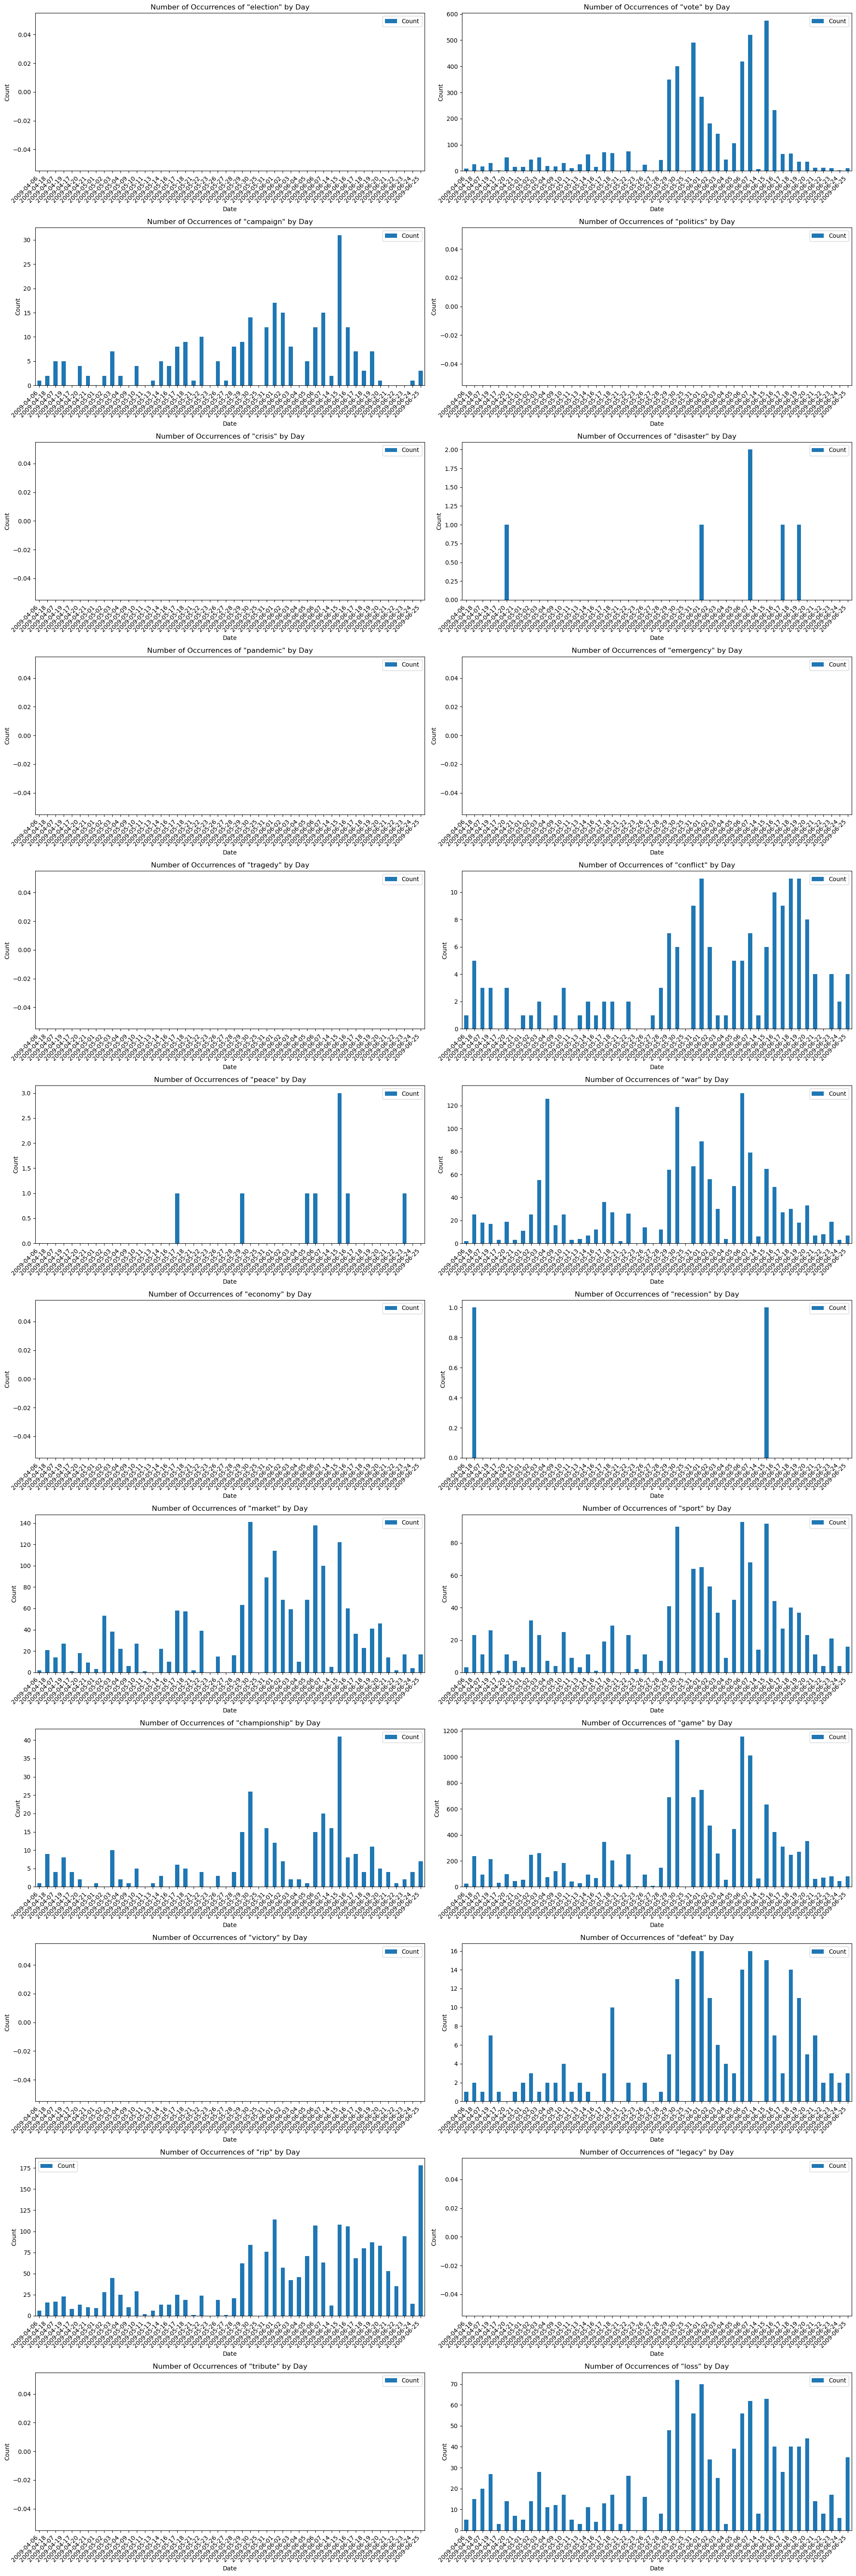

In [181]:
# Plot the number of occurrences of each word in the list by day.
def plot_word_counts(df, words_to_search):

    # Filter out rows where 'cleaned_text' is not NaN
    df_filtered = df[df['cleaned_text'].notna()].copy()

    # Convert 'datetime' column to datetime format
    df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])

    # Extract only the date without time from the 'datetime' column
    df_filtered['date'] = df_filtered['datetime'].dt.date

    # Check if each word has at least one occurrence
    valid_words_to_search = [word for word in words_to_search if (df_filtered['cleaned_text'].str.contains(word)).any()]

    # Plotting word counts for each word
    num_words = len(valid_words_to_search)
    num_rows = (num_words + 1) // 2  # Calculate number of rows for subplots
    plt.figure(figsize=(20, 5 * num_rows))

    for i, word in enumerate(valid_words_to_search, 1):
        word_counts_per_day = {}

        # Iterate over unique dates in the dataset
        for date in df_filtered['date'].unique():
            # Select tweets for the current date
            tweets_date = df_filtered[df_filtered['date'] == date]

            # Combine all tweets' text into a single string for the current date
            all_text = ' '.join(tweets_date['cleaned_text'])

            # Tokenize the text
            tokens = all_text.split()

            # Count the occurrences of the specified word
            word_counts_per_day[date] = tokens.count(word)

        # Convert the dictionary to a DataFrame
        word_counts_df = pd.DataFrame.from_dict(word_counts_per_day, orient='index', columns=['Count'])

        # Plotting the bar plot
        plt.subplot(num_rows, 2, i)
        word_counts_df.plot(kind='bar', ax=plt.gca())
        plt.title(f'Number of Occurrences of "{word}" by Day')
        plt.xlabel('Date')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# List of words to search
words_to_search = ['election', 'vote', 'candidate', 'campaign', 'politics', 'crisis', 'disaster', 
                   'pandemic', 'emergency', 'tragedy', 'terrorism', 'conflict', 'peace', 'negotiation', 
                   'diplomacy', 'war', 'economy', 'recession', 'market', 'inflation', 'unemployment', 
                   'sport', 'championship', 'game', 'victory', 'defeat', 'rip', 'condolences', 'legacy', 
                   'memorial', 'tribute', 'loss']

# Call the function to plot word counts for each word
plot_word_counts(df_tw, words_to_search)


After researching global news and analyzing the statistics of word usage in tweets, the following observations can be made:

There is a sudden rise in the flow of the terms like - "Vote," "Conflict," "Market," "Sport", "Championship", "Game", "Defeat", "RIP.", and "Loss" at the beginning of the June. Possible reasons:
- Politics: June 4-7, 2009 fall on a period when the European Parliament elections take place.
- Sporting events: Many competitions begin when the summer months come.
- Conflict/War: Several shifts in wars happened in Iran and the Gaza Strip.
- On June 1, 2009, there was a crash of Air France Flight 447 that claimed the lives of everyone on board.
- All of these factors may have affected the stock market.

Moreover, on June 25, 2009, there is a sharp increase in the word "RIP". It was on this day that Michael Jackson died. This occurrence must have immediately caused a sudden turn in the mood of the tweets sent by his many fans across the globe on 25 June and the previous day.

The list of the themes and words concerning global events could be extended for the further analysis.

<a class="anchor" id="2.9"></a>
### 2.9 Bigrams, Trigrams, Quadgrams

Bigram, trigram, and quadgram analysis in a text may reveal more deep connections between words and helps enhance the contextual interpretation and discovery of the most often used phrases and expressions. Let's find Top10 bigram, trigram, and quadgram.

In [185]:
# Make a copy of df_tw to avoid modifying the original DataFrame
new_df = df_tw.copy()

# Remove rows with missing values in the 'cleaned_text' column
new_df.dropna(subset=['cleaned_text'], inplace=True)

# Convert values in the 'cleaned_text' column to strings (if missing values have already been removed)
new_df['cleaned_text'] = new_df['cleaned_text'].astype(str)

# Combine the text of all tweets into a single string
all_tweets_text = ' '.join(new_df['cleaned_text'])

# Tokenize the text
tokens = nltk.word_tokenize(all_tweets_text)

# Create bigram, trigram, and quadgram finders
bigram_finder = BigramCollocationFinder.from_words(tokens)
trigram_finder = TrigramCollocationFinder.from_words(tokens)
quadgram_finder = QuadgramCollocationFinder.from_words(tokens)

# Get the most common bigrams, trigrams, and quadgrams
top_10_bigrams = bigram_finder.ngram_fd.most_common(10)
top_10_trigrams = trigram_finder.ngram_fd.most_common(10)
top_10_quadgrams = quadgram_finder.ngram_fd.most_common(10)

# Print the results
print("Top 10 Bigrams:")
print(top_10_bigrams)
print("\nTop 10 Trigrams:")
print(top_10_trigrams)
print("\nTop 10 Quadgrams:")
print(top_10_quadgrams)

Top 10 Bigrams:
[(('gon', 'na'), 23785), (('wan', 'na'), 16557), (('last', 'night'), 12710), (('good', 'morn'), 10219), (('got', 'ta'), 9286), (('feel', 'like'), 9198), (('look', 'like'), 7793), (('wish', 'could'), 7496), (('want', 'go'), 6928), (('get', 'readi'), 6747)]

Top 10 Trigrams:
[(('wan', 'na', 'go'), 4044), (('happi', 'mother', 'day'), 2265), (('im', 'gon', 'na'), 2079), (('gon', 'na', 'miss'), 1880), (('gon', 'na', 'go'), 1831), (('get', 'follow', 'day'), 1488), (('use', 'add', 'everyon'), 1485), (('follow', 'day', 'use'), 1484), (('day', 'use', 'add'), 1484), (('add', 'everyon', 'train'), 1484)]

Top 10 Quadgrams:
[(('get', 'follow', 'day', 'use'), 1484), (('follow', 'day', 'use', 'add'), 1484), (('day', 'use', 'add', 'everyon'), 1484), (('use', 'add', 'everyon', 'train'), 1484), (('add', 'everyon', 'train', 'pay'), 1484), (('everyon', 'train', 'pay', 'vip'), 1484), (('lost', 'pleas', 'help', 'find'), 550), (('pleas', 'help', 'find', 'good'), 550), (('help', 'find', 'good'

Top bigrams, trigrams and quadgrams reveal distinct patterns of linguistic nature in the text data signifying intentions, emotions, greetings, and action specification.

<a class="anchor" id="2.10"></a>
### 2.10 Sentiment Polarity Classifier

<a class="anchor" id="2.10.1"></a>
#### 2.10.1 Creating the model

In [7]:
# Create a copy of df_tw with only 'cleaned_text' and 'polarity' columns
df_copy = df_tw[['cleaned_text', 'polarity']].copy()

# Drop rows with missing values
df_copy.dropna(inplace=True)

In [8]:
# Split the data into input features (X) and target variable (y)
X = df_copy['cleaned_text']
y = df_copy['polarity']

In [9]:
# Encode the categorical 'polarity' labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [10]:
# Tokenize the text data
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

In [14]:
# Pad sequences to ensure uniform length
max_len = max([len(x) for x in X])
X = pad_sequences(X, maxlen=max_len)

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1278156, 48), (319539, 48), (1278156,), (319539,))

Let's develop a classification model to forecast tweet’s polarity.

The model consists of:
-	Embedding Layer: Transforms the sequences into vector representations with 100 dimensions to catch semantic relationships.
-	SpatialDropout1D Layer: Uses dropout (0.2) to avoiding overfitting.
-	 LSTM Layer: 100 units with dropout and recurrent dropout modes (0. 2) to capture long-term dependencies in the sequence data.
-	Dense Layer: Softmax activation for classification with 3 units
-	The model is made using sparse categorical crossentropy loss, the adam optimizer for effective gradient descent and accuracy metric for performance evaluation.

In [13]:
# Model building
embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))

model.add(SpatialDropout1D(0.2))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

'Sparse_categorical_crossentropy' along with the 'label-encoding', rather than one-hot encoding, can be memory-efficient and faster in terms of computations. A class label will be represented by an integer just once in label encoding, reducing the overall memory usage. Furthermore, for the losses, the neural network consumes only the index of the correct class for each example and not the entire one-hot vector of predicted class probabilities. This cuts the computational time, particularly, if the datasets are large.

In [14]:
# Model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 48, 100)           500000    
                                                                 
 spatial_dropout1d (Spatial  (None, 48, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 580703 (2.22 MB)
Trainable params: 580703 (2.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [29]:
# Model training
epochs = 5
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
19972/19972 [==============================] - 1206s 60ms/step - loss: 0.0819 - accuracy: 0.9793 - val_loss: 0.0722 - val_accuracy: 0.9832
Epoch 2/5
19972/19972 [==============================] - 1238s 62ms/step - loss: 0.0708 - accuracy: 0.9830 - val_loss: 0.0688 - val_accuracy: 0.9847
Epoch 3/5
19972/19972 [==============================] - 1179s 59ms/step - loss: 0.0669 - accuracy: 0.9846 - val_loss: 0.0667 - val_accuracy: 0.9856
Epoch 4/5
19972/19972 [==============================] - 1212s 61ms/step - loss: 0.0645 - accuracy: 0.9853 - val_loss: 0.0654 - val_accuracy: 0.9860
Epoch 5/5
19972/19972 [==============================] - 1209s 61ms/step - loss: 0.0630 - accuracy: 0.9857 - val_loss: 0.0652 - val_accuracy: 0.9860


In [32]:
# Model evaluation
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

9986/9986 [==============================] - 68s 7ms/step - loss: 0.0652 - accuracy: 0.9860
Test Loss: 0.06516999751329422
Test Accuracy: 0.9859892129898071


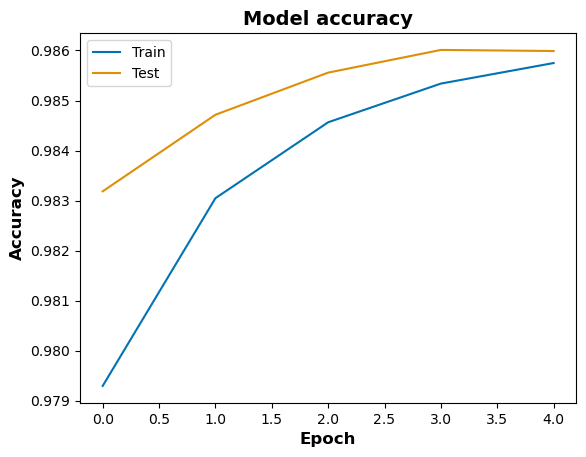

In [82]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy', fontsize=14, fontweight="bold")
plt.xlabel('Epoch', fontsize=12, fontweight="bold")
plt.ylabel('Accuracy', fontsize=12, fontweight="bold")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [39]:
# Predictions on test data
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)

9986/9986 [==============================] - 57s 6ms/step


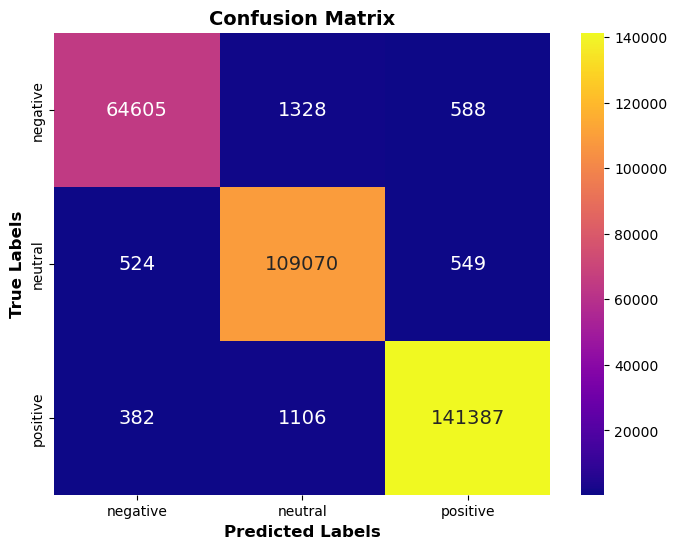

In [57]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="plasma", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, annot_kws={"size": 14})
plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Labels", fontsize=12, fontweight="bold")
plt.ylabel("True Labels", fontsize=12, fontweight="bold")
plt.show()

In [37]:
# Classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     66521
           1       0.98      0.99      0.98    110143
           2       0.99      0.99      0.99    142875

    accuracy                           0.99    319539
   macro avg       0.99      0.98      0.98    319539
weighted avg       0.99      0.99      0.99    319539



The classification report shows good scores across all classes with a high precision, recall, and F1-score, therefore overall accuracy is 99%. This means that the sentiment polarity classifier had the high level of precision in classifying tweets into the appropriate sentiment categories.

<a class="anchor" id="2.10.2"></a>
#### 2.10.2 Hyperparameter tuning

I decided to use a method of RandomizedSearchCV as it can efficiently handle large volumes of data. It randomly samples hyperparameter combinations from the defined distributions, thus being efficient for exploration through a wide spectrum of parameters without intrusive searching of the entire parameter space.

In [22]:
# Define the function to create the model
def create_model(embedding_dim=100, dropout_rate=0.2, lstm_units=100, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(dropout_rate))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Create a KerasClassifier based on the create_model function
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=64, verbose=1)

param_grid = {
    'embedding_dim': [50, 100, 200],
    'dropout_rate': [0.1, 0.2, 0.3],
    'lstm_units': [50, 100, 150],
    'optimizer': ['adam', 'rmsprop']
}

# Perform randomized search with early stopping
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=3, verbose=1)
random_result = random_search.fit(X_train, y_train, callbacks=[early_stopping])

# Print the results of hyperparameter tuning
print("Best accuracy: %.4f using %s" % (random_result.best_score_, random_result.best_params_))

/var/folders/nt/b21sklbj23v0b307kmp0jd600000gn/T/ipykernel_44192/3417813519.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=64, verbose=1)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/5
13315/13315 [==============================] - 591s 44ms/step - loss: 0.1208 - accuracy: 0.9661
Epoch 2/5
13315/13315 [==============================] - 589s 44ms/step - loss: 0.0785 - accuracy: 0.9805
Epoch 3/5
13315/13315 [==============================] - 585s 44ms/step - loss: 0.0727 - accuracy: 0.9824
Epoch 4/5
13315/13315 [==============================] - 603s 45ms/step - loss: 0.0694 - accuracy: 0.9834
Epoch 5/5
6658/6658 [==============================] - 51s 8ms/step - loss: 0.0663 - accuracy: 0.9852
Epoch 1/5
13315/13315 [==============================] - 581s 44ms/step - loss: 0.1218 - accuracy: 0.9660
Epoch 2/5
13315/13315 [==============================] - 595s 45ms/step - loss: 0.0780 - accuracy: 0.9806
Epoch 3/5
13315/13315 [==============================] - 635s 48ms/step - loss: 0.0726 - accuracy: 0.9824
Epoch 4/5
13315/13315 [==============================] - 612s 46ms/step - loss: 0.0694 - accurac

In [23]:
# Save the best performing model to a file
best_model = random_result.best_estimator_
best_model.model.save('best_model_sentiment.h5')

In [26]:
# Evaluate the best model on the test set
test_accuracy = best_model.score(X_test, y_test, verbose=1)
print("Accuracy on test set: {:.4f}".format(test_accuracy))

4993/4993 [==============================] - 81s 16ms/step - loss: 0.0642 - accuracy: 0.9865
Accuracy on test set: 0.9865


The best accuracy 0.9855 show the model with the following parameters: optimizer - adam, lstm units - 150, embeddingdim - 100, dropout rate - 0.2.

In [ ]:
spark.stop()